In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import sys
from websockets.sync.client import connect
import time

def error_check(res):
    if res.status_code != 200:
        print(res.text)
        sys.exit(1)

In [2]:
center_freq = int(100e6)
maiasdr_url = "http://192.168.2.5:8000"
samp_rate = int(50e6)
rx_gain = int(50)
spectrum_rate = float(40)
integrations = int(spectrum_rate)

response = requests.patch(maiasdr_url + '/api/ad9361', json={
        'sampling_frequency': samp_rate,
        'rx_rf_bandwidth': samp_rate,
        'rx_lo_frequency': center_freq,
        'rx_gain': rx_gain,
        'rx_gain_mode': 'Manual',})
error_check(response)

response = requests.patch(maiasdr_url + '/api/spectrometer',json={'output_sampling_frequency': spectrum_rate,})
error_check(response)

ws_url = 'ws:' + ':'.join(maiasdr_url.split(':')[1:]) + '/waterfall'

t0 = time.time()

with connect(ws_url) as ws:
    specs = np.zeros([integrations, 4096])
    for i in range(integrations):
        specs[i, :] = np.frombuffer(ws.recv(), 'float32')
    spec = np.average(specs, axis=0)

t1 = time.time()

print (t1-t0)

0.9836716651916504


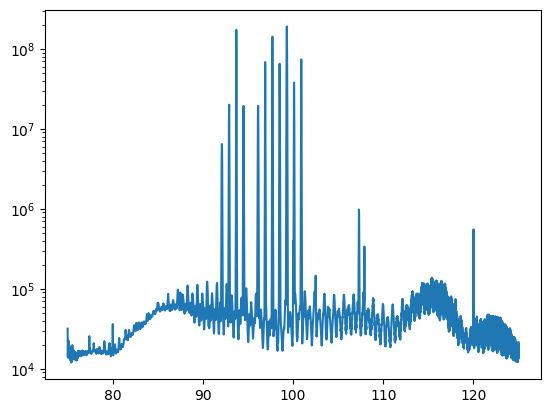

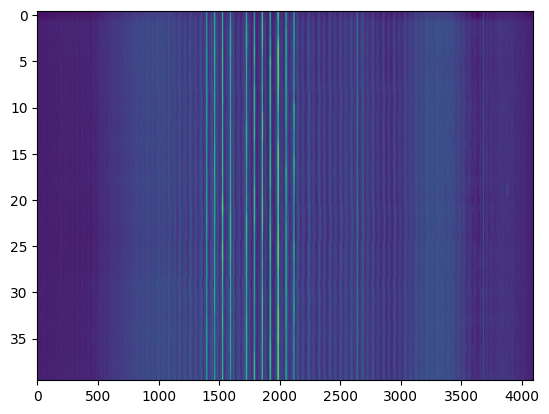

In [3]:
freq = np.linspace((center_freq-samp_rate/2), center_freq+(samp_rate/2), 4096)

plt.figure()
# plt.plot(freq/1e6, spec)
plt.semilogy(freq/1e6, spec)

# for fm_freq in [92.1, 92.9, 93.7, 94.5, 96.1, 96.9, 97.7, 98.5, 100.1]:
#     plt.axvline(fm_freq, color='red')
# plt.xlim(88,108)

plt.figure()
plt.imshow(np.log(specs), aspect='auto')